# Stroke Predictor - DSCI 100 Group Project Report

## 1. Introduction

The chances of getting a stroke can often be predicted by certain factors such as glucose level and smoking status. Being able to tell a person if they are categorized to have a higher chance of stroke gives a person a chance to reduce said factors in hopes of preventing a stroke. The question and purpose of our project is to classify a large set of data that gives the factors that lead to stroke and then, when given a new example, predict if the person is likely to have a stroke.
The data set is provided on Kaggle (https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset), which lists various background clinical features from the patients, such as disease history and age, all potentially useful in predicting a stroke. 

Below are some preliminary exploratory data analysis to visualize the data before classifying it.

## 2. Exploratory data analysis

In [1]:
### LOADING LIBRARY

### Run this cell before continuing.
library(plyr)
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
install.packages("themis")
library(themis)


options(repr.matrix.max.rows = 6)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()   masks plyr::arrange()
✖ purrr::compact()   masks plyr::compact()
✖ dplyr::count()     masks plyr::count()
✖ dplyr::failwith()  masks plyr::failwith()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::id()        masks plyr::id()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::mutate()    masks plyr::mutate()
✖ dplyr::rename()    masks plyr::rename()
✖ dplyr::summarise() masks plyr::summarise()
✖ dplyr::summarize() masks plyr::summarize()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ mod

### Read dataset from web into R

In [2]:
url <- "https://gist.githubusercontent.com/aishwarya8615/d2107f828d3f904839cbcb7eaa85bd04/raw/cec0340503d82d270821e03254993b6dede60afb/healthcare-dataset-stroke-data.csv"
stroke_data <- read_csv(url)

## modify variable types
stroke_data_final <- stroke_data |>
                    mutate (stroke = as.factor(stroke),
                           bmi = as.numeric(bmi))
stroke_data_final

Rows: 5110 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): gender, ever_married, work_type, Residence_type, bmi, smoking_status
dbl (6): id, age, hypertension, heart_disease, avg_glucose_level, stroke

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<fct>
9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61,0,0,Yes,Self-employed,Rural,202.21,NA,never smoked,1
31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
19723,Female,35,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
37544,Male,51,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0
44679,Female,44,0,0,Yes,Govt_job,Urban,85.28,26.2,Unknown,0


**Table 2.1** Stroke data set.

    1) id: unique identifier
    2) gender: "Male", "Female" or "Other"
    3) age: age of the patient
    4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
    5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
    6) ever_married: "No" or "Yes"
    7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
    8) Residence_type: "Rural" or "Urban"
    9) avg_glucose_level: average glucose level in blood
    10) bmi: body mass index
    11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
    12) stroke: 1 if the patient had a stroke or 0 if not

To view what correlation various factors have on developing stroke, we will plot three scatter graphs: age vs. average glucose level, age vs. BMI, and BMI vs. average glucose level. These three variables were chosen because they were continuous measurements and are closely related to the develpopment of stroke as shown in Table 2.1. 

Splitting the dataset into training and testing datasets based on stroke history. Since we only consider continuous variables, we will be selecting only those columns from the original data set before doing the data split. 

In [3]:
set.seed(1)

# also remove rows with N/A data
stroke_data_final_selected <- stroke_data_final |> 
    select(age,avg_glucose_level,bmi,stroke) |> 
    drop_na()

stroke_split <- initial_split(stroke_data_final_selected, prop = 0.75, strata = stroke)
stroke_train <- training(stroke_split)
stroke_test <- testing(stroke_split)

### Preliminary Summary

The tables below show the min and the max of each continous feature when a person has or has not a stroke. This is important when determining the valid ranges of the data and allow us to comfrim results.

In [4]:
factors_with_stroke <- filter(stroke_train, stroke == 1)
factors_without_stroke <- filter(stroke_train, stroke == 0)


min_max <- list(
  min = ~min(.x, na.rm = TRUE), 
  max = ~max(.x, na.rm = TRUE)
)

avg <- list(
  avg = ~mean(.x, na.rm = TRUE)
)


factors_with_stroke |> summarise(across(where(is.numeric), min_max)) 


age_min,age_max,avg_glucose_level_min,avg_glucose_level_max,bmi_min,bmi_max
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
14,82,56.11,263.32,16.9,48.9


**Table 2.2** Ranges of factors for people who had a stroke

    1) Age minimum: The youngest person recorded to have a stroke
    2) Age maximum: The oldest person recored to have a stroke
    3) Averge minimum glucose level: lowest glucose level of person who had a stroke recorded
    4) Averge maximum glucose level : Highest glucose level of person who had a stroke recorded
    5) Minimum BMI: lowest BMI recored for a person who had a stoke.
    6) Maximum BMI: Highest BMI recored for a person who had a stoke.
 

In [5]:
factors_without_stroke |> summarise(across(where(is.numeric), min_max))

age_min,age_max,avg_glucose_level_min,avg_glucose_level_max,bmi_min,bmi_max
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.08,82,55.12,267.61,10.3,97.6


**Table 2.3** Ranges of factors for people who didn't have a stroke

    1) Age minimum: The youngest person recorded to not have a stroke
    2) Age maximum: The oldest person recored to not have a stroke
    3) Averge minimum glucose level: lowest glucose level of person who didn't have a stroke recorded
    4) Averge maximum glucose level : Highest glucose level of person who didn't have a stroke recorded
    5) Minimum BMI: lowest BMI recored for a person who didn't have a stoke.
    6) Maximum BMI: Highest BMI recored for a person who didn't have a stoke.

The tables below show the average of each continous feature when people have or have not a stroke. This shows us what glucose level may indicate aa chance for stroke.

In [6]:
factors_with_stroke |> summarise(across(where(is.numeric), avg))


age_avg,avg_glucose_level_avg,bmi_avg
<dbl>,<dbl>,<dbl>
67.75,132.6676,30.34615


**Table 2.4** Averages of features of people who had a stroke

    1) Average Age: Average age of all people who were recorded to have a stroke
    2) Average Glucose level: Average glucose level of all people who were recorded to have a stroke
    3) Average BMI: Average BMI of all people who were recorded to have a stroke

In [7]:
factors_without_stroke |> summarise(across(where(is.numeric), avg))

age_avg,avg_glucose_level_avg,bmi_avg
<dbl>,<dbl>,<dbl>
41.61872,103.2145,28.7486


**Table 2.5** Averages of features of people who did not have a stroke

    1) Average Age: Average age of all people who were recorded to not have a stroke
    2) Average Glucose level: Average glucose level of all people who were recorded to not have a stroke
    3) Average BMI: Average BMI of all people who were recorded to not have a stroke

The table below shows how many cells with missing data are present in each column. This is important as we need to exclude any examples which may have incomplete data

In [8]:
stroke_bmi <- sum(is.na(factors_with_stroke$bmi))
stroke_avg_glucos <- sum(is.na(factors_with_stroke$avg_glucose_level))
stroke_age <- sum(is.na(factors_with_stroke$age))
no_stroke_bmi <- sum(is.na(factors_without_stroke$bmi))
no_stroke_averge_glucose <- sum(is.na(factors_without_stroke$avg_glucose_level))
no_stroke_age <- sum(is.na(factors_without_stroke$age))

missing_data <- tibble("With stroke: Bmi" = stroke_bmi, "With stroke: Avg Glucose" = stroke_avg_glucos, "With stroke: Age" = stroke_bmi, 
            "Without stroke: Bmi" = no_stroke_bmi, "Without stroke: Avg Glucose" = no_stroke_averge_glucose, "Without stroke: Age" = no_stroke_age)
missing_data

With stroke: Bmi,With stroke: Avg Glucose,With stroke: Age,Without stroke: Bmi,Without stroke: Avg Glucose,Without stroke: Age
<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0


**Table 2.6** Number of examples that have missing data in the associated feature

    1) With Stroke: BMI: The number of examples that have missing data in this set
    1) With Stroke: Averge Glucose: The number of examples that have missing data in this set
    1) With Stroke Age: The number of examples that have missing data in this set
    1) Without Stroke BMI: The number of examples that have missing data in this set
    1) Without Stroke Averge Glucose: The number of examples that have missing data in this set
    1) Without Stroke AGE: The number of examples that have missing data in this set

### Preliminary Data Visualization

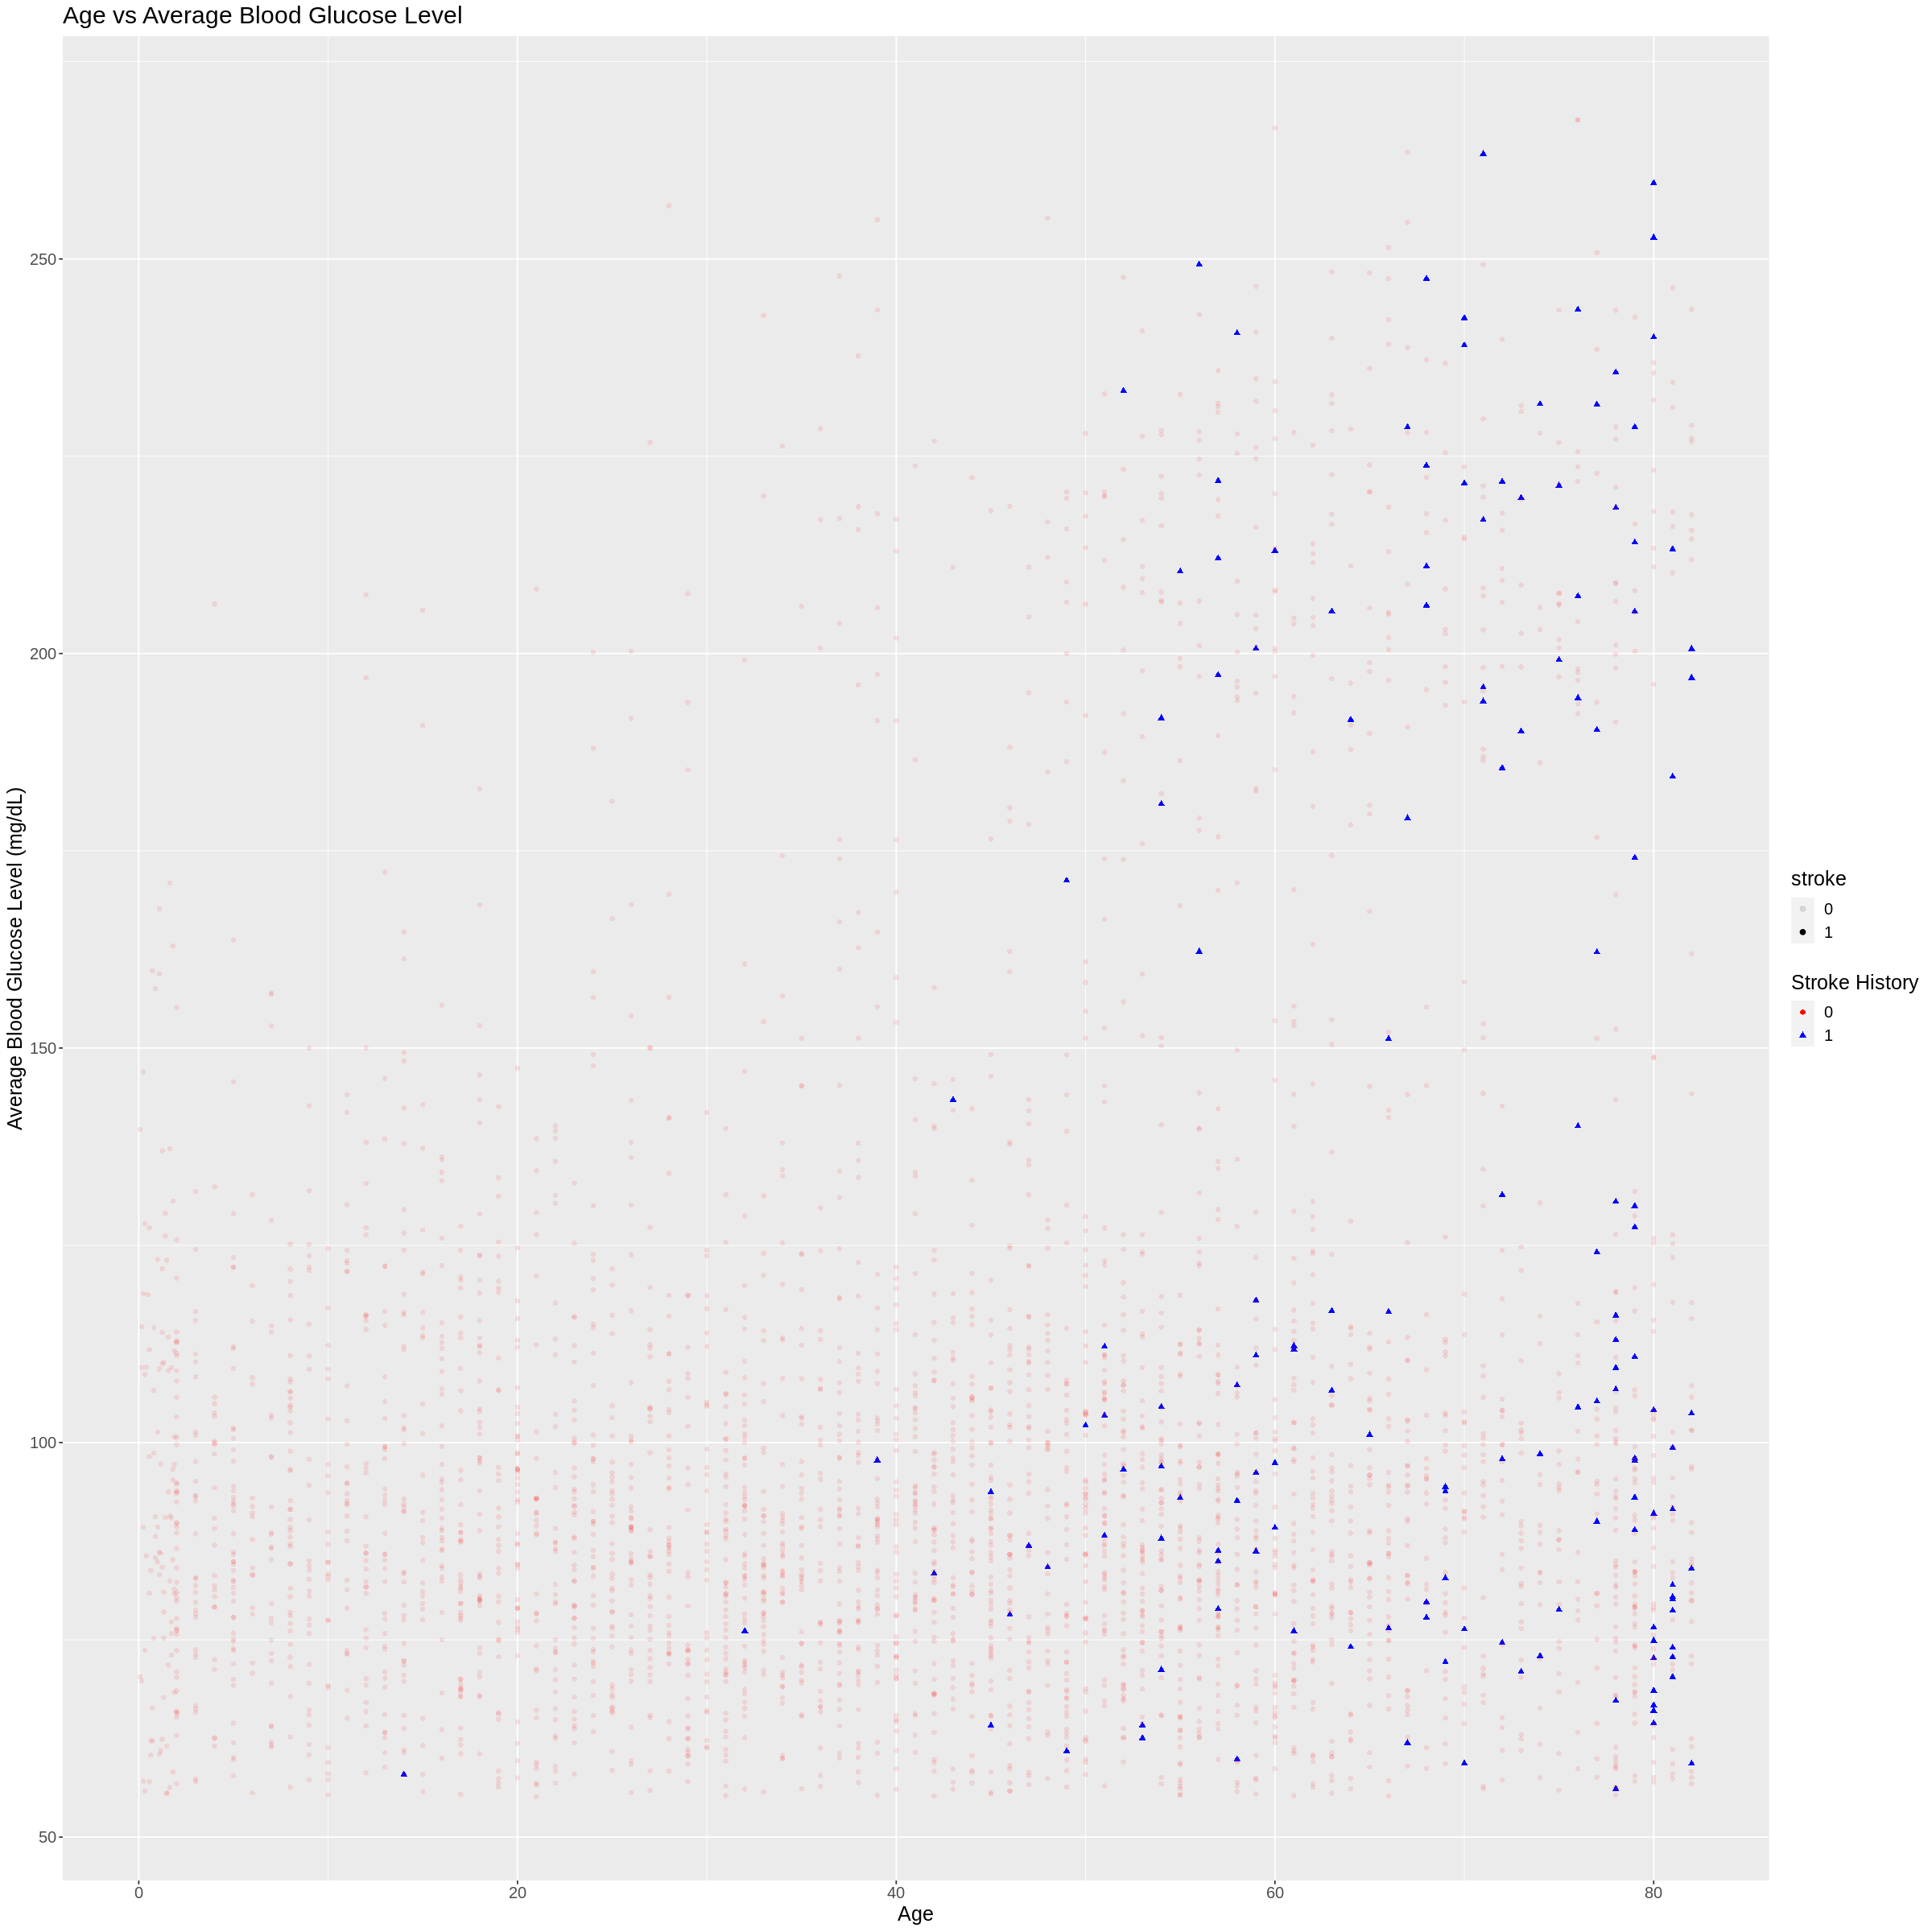

In [9]:
options(repr.plot.width = 20, repr.plot.height = 20)

age_vs_glucose <- ggplot (stroke_train, aes(x=age, y=avg_glucose_level, color= stroke,shape= stroke))+
                geom_point(aes(alpha = stroke,shape= stroke))+
                scale_alpha_manual(values = c(0.1, 1))+
                scale_color_manual(values = c("red", "blue"))+
                labs(x="Age", y="Average Blood Glucose Level (mg/dL)", color = "Stroke History",shape = "Stroke History")+
                ggtitle("Age vs Average Blood Glucose Level")+
                theme(text = element_text(size = 15))
age_vs_glucose



**Graph 2.1: Age vs Average Blood Glucose Level** - Looking at the graph, we can see that there is a cluster of exmaples who experinced a stoke alongside a cluster of high blood glucose. There is another cluster where age is high as well but this to be expected. To have a cluster where there is also a cluster of high blood glucose means that there is a correlation between the two factors and can be related

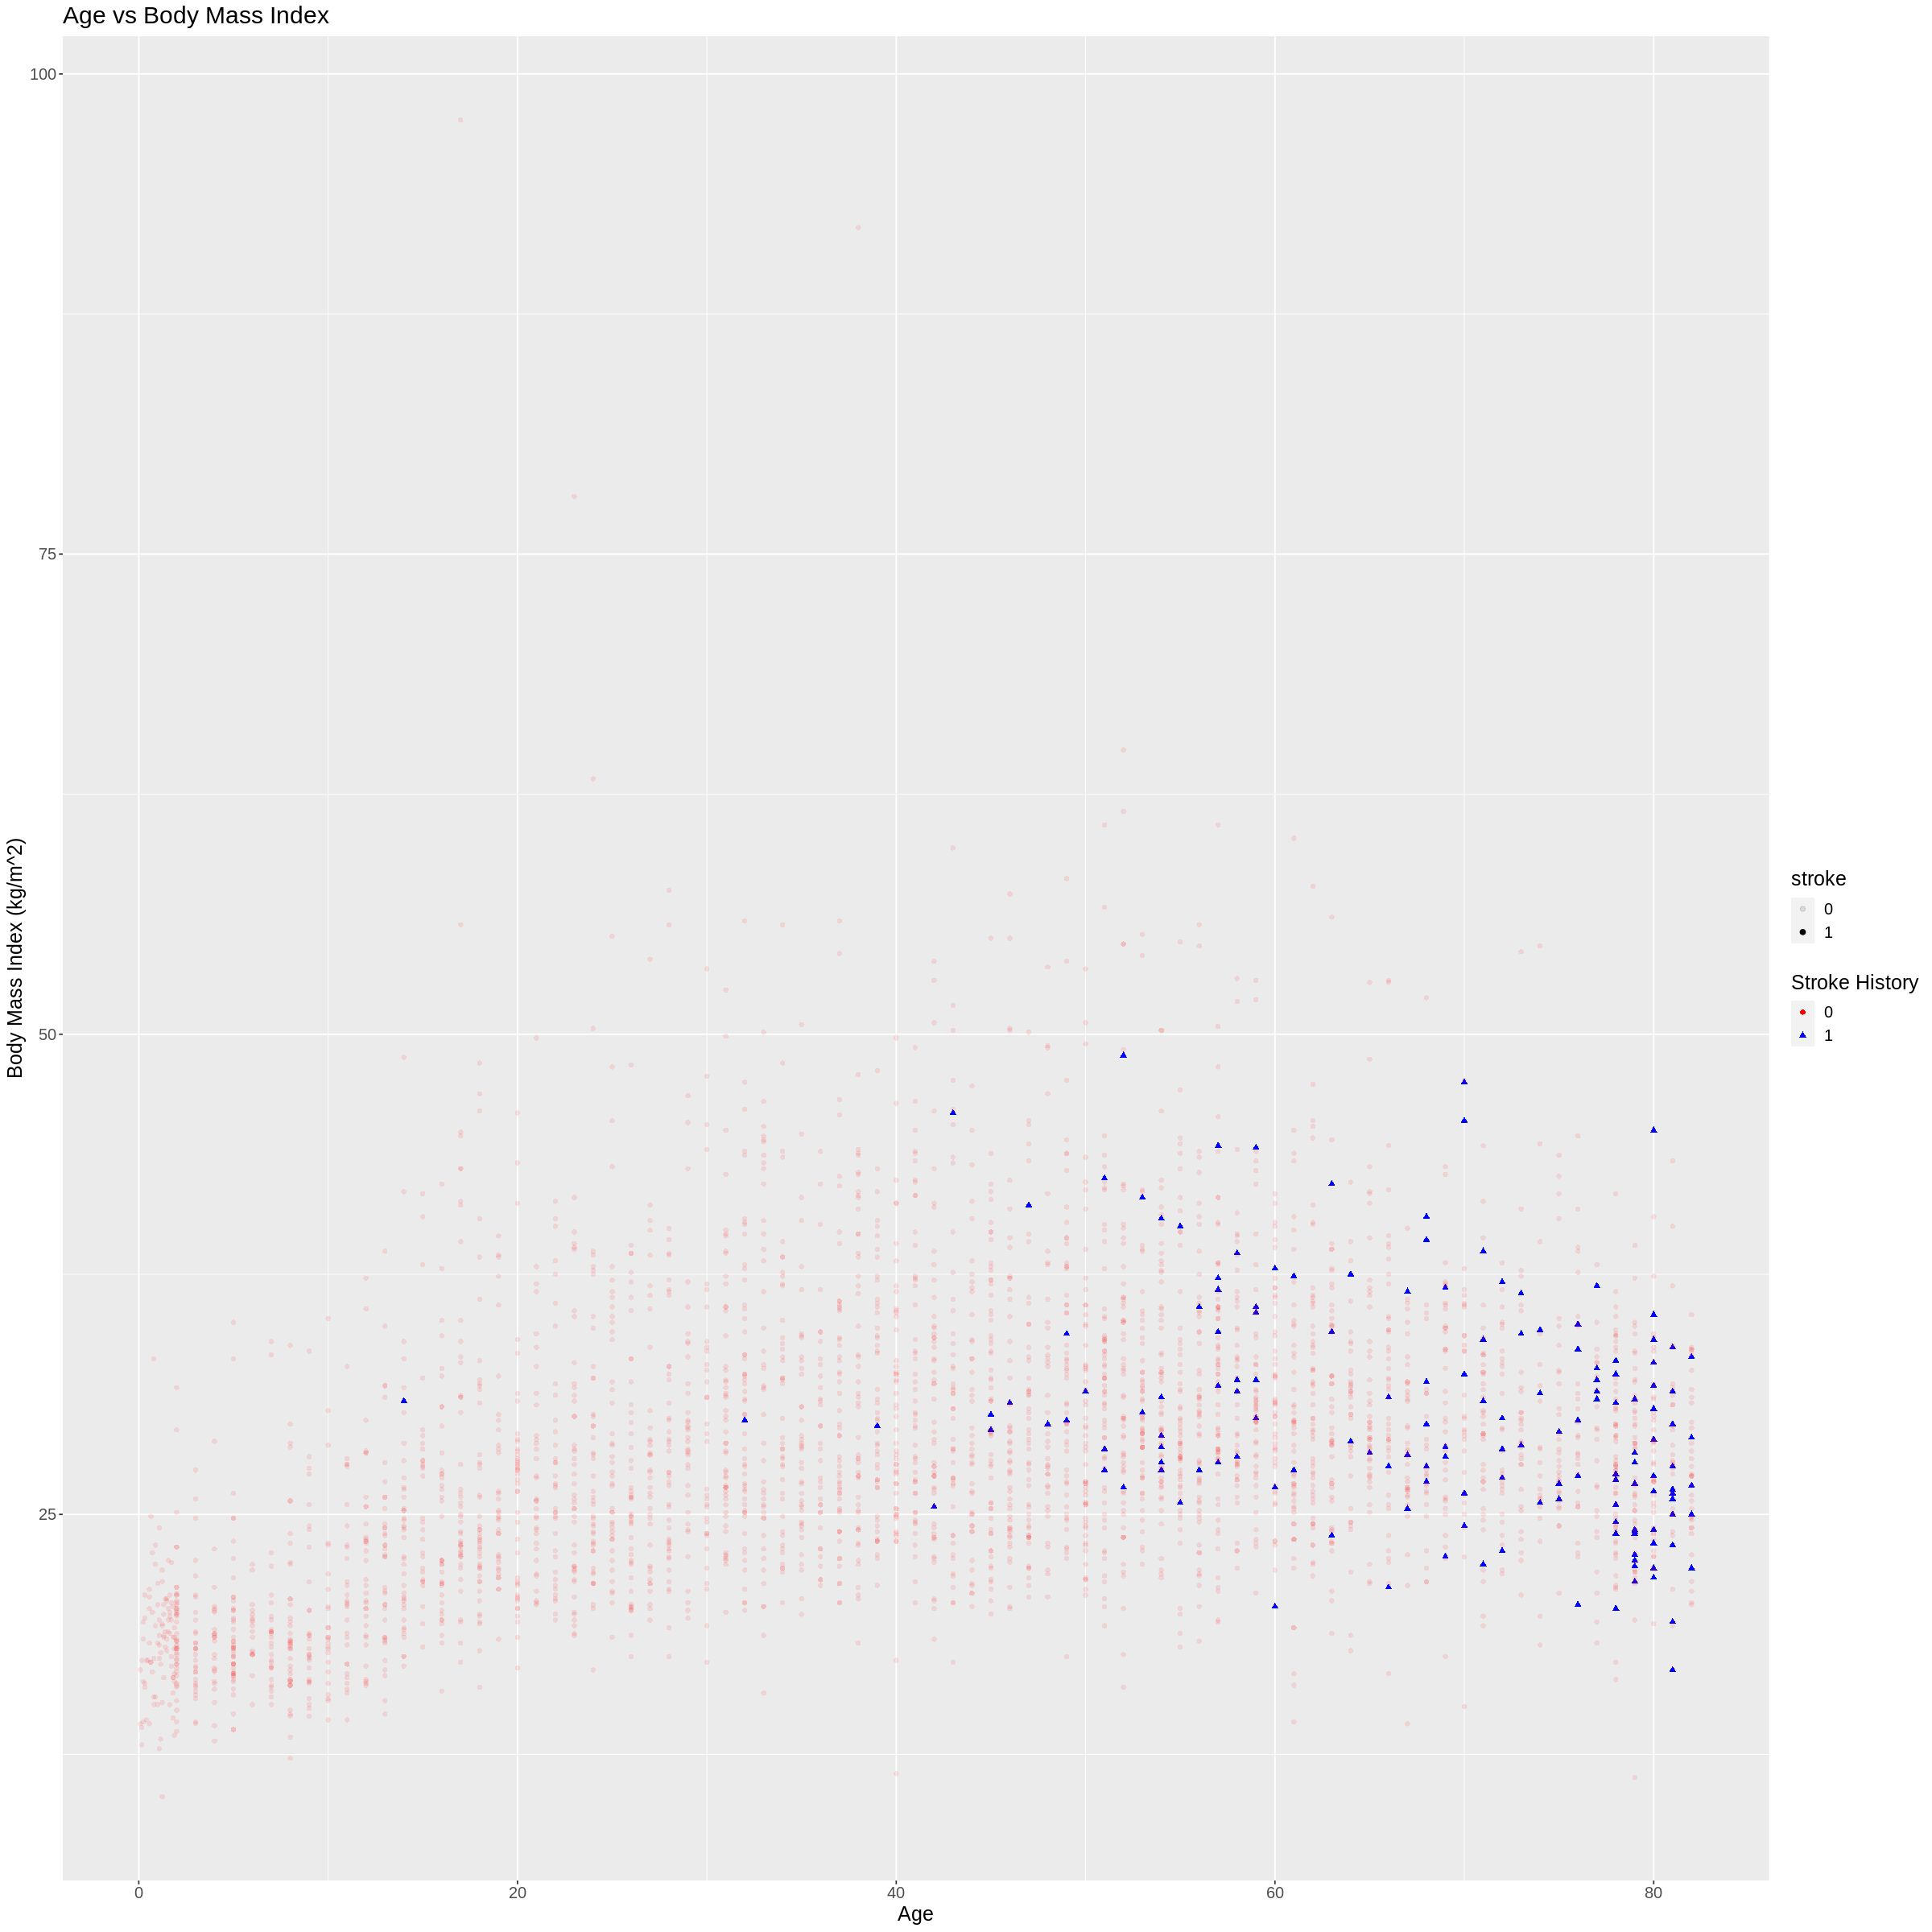

In [10]:
age_vs_bmi <- ggplot (stroke_train, aes(x=age, y=bmi, color= stroke,shape=stroke))+
                geom_point(aes(alpha = stroke,shape=stroke))+
                scale_alpha_manual(values = c(0.1, 1))+
                scale_color_manual(values = c("red", "blue"))+
                labs(x="Age", y="Body Mass Index (kg/m^2)", color = "Stroke History",shape = "Stroke History")+
                ggtitle("Age vs Body Mass Index")+
                theme(text = element_text(size = 15))
age_vs_bmi
options(repr.plot.width = 15, repr.plot.length = 20)

**Graph 2.2: Age vs Body Mass Index** - Here we see a strong correlation between age and having a stroke, meaning the we can consider being at a older age brings a higher chance of a stroke

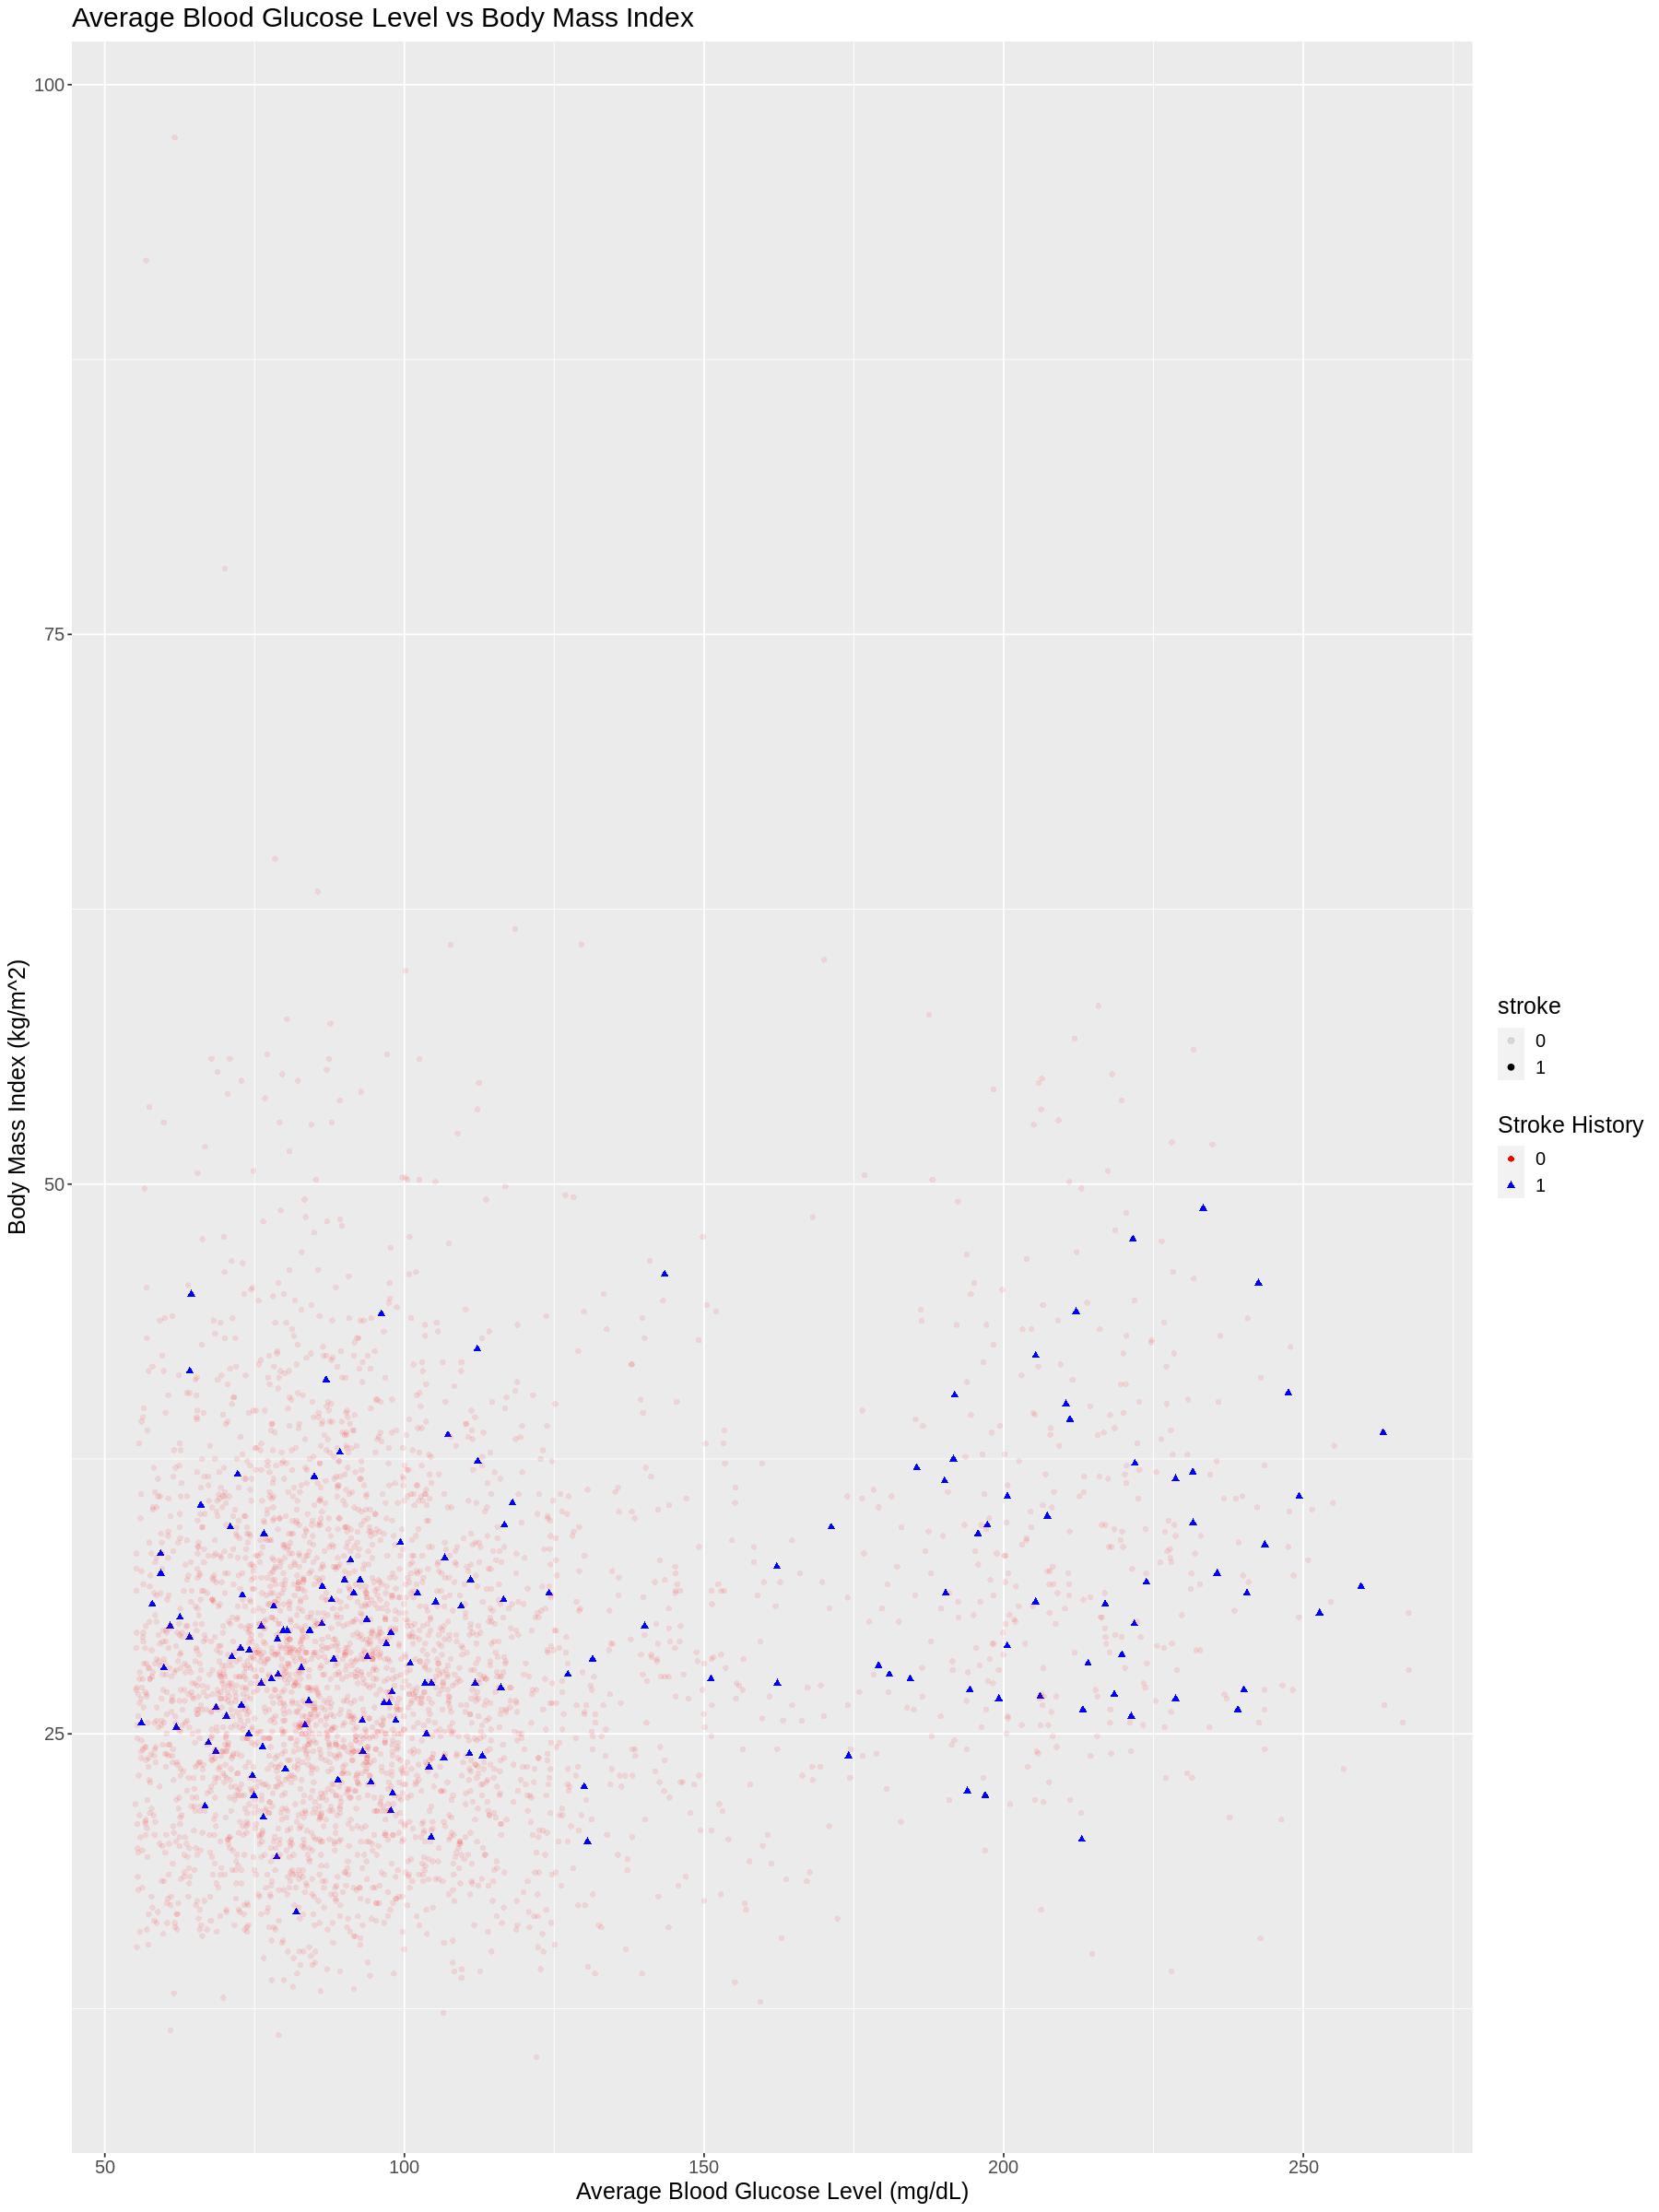

In [11]:
avg_glucose_vs_bmi <- ggplot (stroke_train, aes(x=avg_glucose_level, y=bmi, color= stroke,shape=stroke))+
                geom_point(aes(alpha = stroke,shape=stroke))+
                scale_alpha_manual(values = c(0.1, 1))+
                scale_color_manual(values = c("red", "blue"))+
                labs(x="Average Blood Glucose Level (mg/dL)", y="Body Mass Index (kg/m^2)", color = "Stroke History",shape = "Stroke History")+
                ggtitle("Average Blood Glucose Level vs Body Mass Index")+
                theme(text = element_text(size = 15))
avg_glucose_vs_bmi
options(repr.plot.width = 15, repr.plot.length = 20)

**Grpah 2.3: Average Blood Glucose Level vs Body Mass Index** - Now comparing BMI and glucose level we can see two localized clusters when Body index mass is low and glucose levels is in the extreme low or high, this can be looked at further later.

## Data Analysis

### Methods

We use classification since we are more interested in predicting potential strokes rather than finding dependency relationship between stroke and other variables (regression). While the latter helps with finding out causes of stroke (and how strongly they contribute to stroke), classification provides a useful warning as it allows the patient to be more aware of their lifestyle and allows doctors to be more proactive in diagnosis and treatment.

To build our model, we split our initial data so that 75% (seem to be the standard percentage) will be used in the training data and the rest for the test data. We also need to set a seed so that the code is reproducible. We will then build the model using the optimal K value found from tuning the number of nearest neighbors on the training data. (This has been done in the EDA)

We are using K-nearest neighbours classification since we are trying to predict and categorize an example into two groups, having a stroke and not having a stroke. KNN works best with categeorical data and clustering (Campbell et al., 2022). As seen with the peliminary data analysis, in Graph 2.1,2.2, and 2.3, we can see our data tends to cluster so this would be an apporiate model to use. Then once this is trained, we can obtain a new example and predict weather or not this person will have a stroke.

Three columns from the dataset will be used in this study: age, BMI, and average blood glucose level. The properties of these features are explored in Tables 2.2, 2.3, 2.4 and 2.5. These three variables are chosen not only because they are three important factors that contribute to an individual’s risk of developing stroke, but their continuous property makes it easier to establish the correlation with having a stroke. To visualize the relationship between the three factors and with stroke, we will produce three scatter plots: age vs. BMI, age vs. average blood glucose level, and finally BMI vs. average blood glucose level as shown in Graph 2.1,2.2, and 2.3.

We also note that our data set is heavily unbalanced, in which the number of observations in the majority class (non-stroke) is roughly 20 times bigger compared to the number of observations in the minority (stroke). 

We are downsampling our data because since there are so many examples of people who have not experienced a stroke. This results in the model having tendency to misclassify people having strokes to be in non-stroke group. This drowns out the intricate details we are trying to find that may indicate one person is likely to have a stroke. We have learned that picking a random sample of a population is just as effective to use data of the whole population so we are using this knowlege here, by using equal parts of the data which uses exmaples who have and haven't had a stroke.

In [12]:
stroke_count <- stroke_data_final |>
    count(stroke)
stroke_count

stroke,n
<fct>,<int>
0,4861
1,249


**Table 3.1** Number of examples where the patients did or did not experince a stroke

    1) Stroke: Binary indicated if a person had a stroke or not, 0 did not have a stroke, 1 did have a stroke
    1) n: the number of examples that did or did not have a stroke assosiated with the above indicators 

In medical scenarios, these situations are generally expected. Since the data set is unbalanced, this would mean a that new observations will be too heavily influenced by the majority class (Dev et al., 2022). Thus, rebalancing the data is necessary, and as Dev et al. has suggested, downsampling is recommended as it helps reduce this adverse effect and, in fact, is used as part of the authors' experiment in classifying strokes. Downsampling is also well-known around nearest neighbors algorithm (Lee et al., 2022). Therefore, we will apply downsampling on the current data set, as it has been shown to work effectively.'step_downsample' allows us to do so, as we specify the 'under_ratio' specifying the ratio $\frac{\text{#majority}}{\text{#minority}}$. Setting it to be 1.85 means that we will be cutting down majority class data until the number of majority class data is $1.85$ times the number of minority class data.

In [19]:
# Set the seed 
set.seed(1)

#Training and Testing (done in EDA)

# # Rebalance the traning data (downsampling)
up_rec <- recipe(stroke ~ ., data = stroke_train) |>
    step_downsample(stroke, under_ratio = 1.85) |>
    prep()

stroke_train_balance <- up_rec |>
    bake(new_data = NULL)


# # recipe // spec // workflow 
stroke_recipe<- recipe(stroke ~. , data = stroke_train_balance) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
                              set_engine("kknn") |>
                              set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 100))
stroke_vfold <- vfold_cv(stroke_train_balance, v = 10, strata = stroke)

knn_results <- workflow() |>
    add_recipe(stroke_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = stroke_vfold, grid = k_vals) |>
    collect_metrics() 
knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6621059,10,0.02741736,Preprocessor1_Model001
1,roc_auc,binary,0.6366851,10,0.02818646,Preprocessor1_Model001
2,accuracy,binary,0.6621059,10,0.02741736,Preprocessor1_Model002
⋮,⋮,⋮,⋮,⋮,⋮,⋮
99,roc_auc,binary,0.8277638,10,0.02772733,Preprocessor1_Model099
100,accuracy,binary,0.7563601,10,0.02743859,Preprocessor1_Model100
100,roc_auc,binary,0.8267365,10,0.02776229,Preprocessor1_Model100


**Table 3.2** Results from the KNN classifier

    1) neighbors: number of neighbours used in classification
    2) .metric: they type of metric used for classifcation, used either accuracy or roc_auc
    3) .estimator: type of the estimator, always binary here
    4) mean: mean of the model
    5) n: the number of folds done
    6) std_err: standard error of the model
    7) .config: configuation of the model 

In [20]:
accuracies <- knn_results |>
    filter(.metric == "accuracy")
accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6621059,10,0.02741736,Preprocessor1_Model001
2,accuracy,binary,0.6621059,10,0.02741736,Preprocessor1_Model002
3,accuracy,binary,0.7071153,10,0.02712064,Preprocessor1_Model003
⋮,⋮,⋮,⋮,⋮,⋮,⋮
98,accuracy,binary,0.7632335,10,0.02760582,Preprocessor1_Model098
99,accuracy,binary,0.7563601,10,0.02743859,Preprocessor1_Model099
100,accuracy,binary,0.7563601,10,0.02743859,Preprocessor1_Model100


**Table 3.3** Results from the KNN classifier

    1) neighbors: number of neighbours used in classification
    2) .metric: they type of metric used for classifcation, used either accuracy
    3) .estimator: type of the estimator, always binary here
    4) mean: mean of the model
    5) n: the number of folds done
    6) std_err: standard error of the model
    7) .config: configuation of the model 

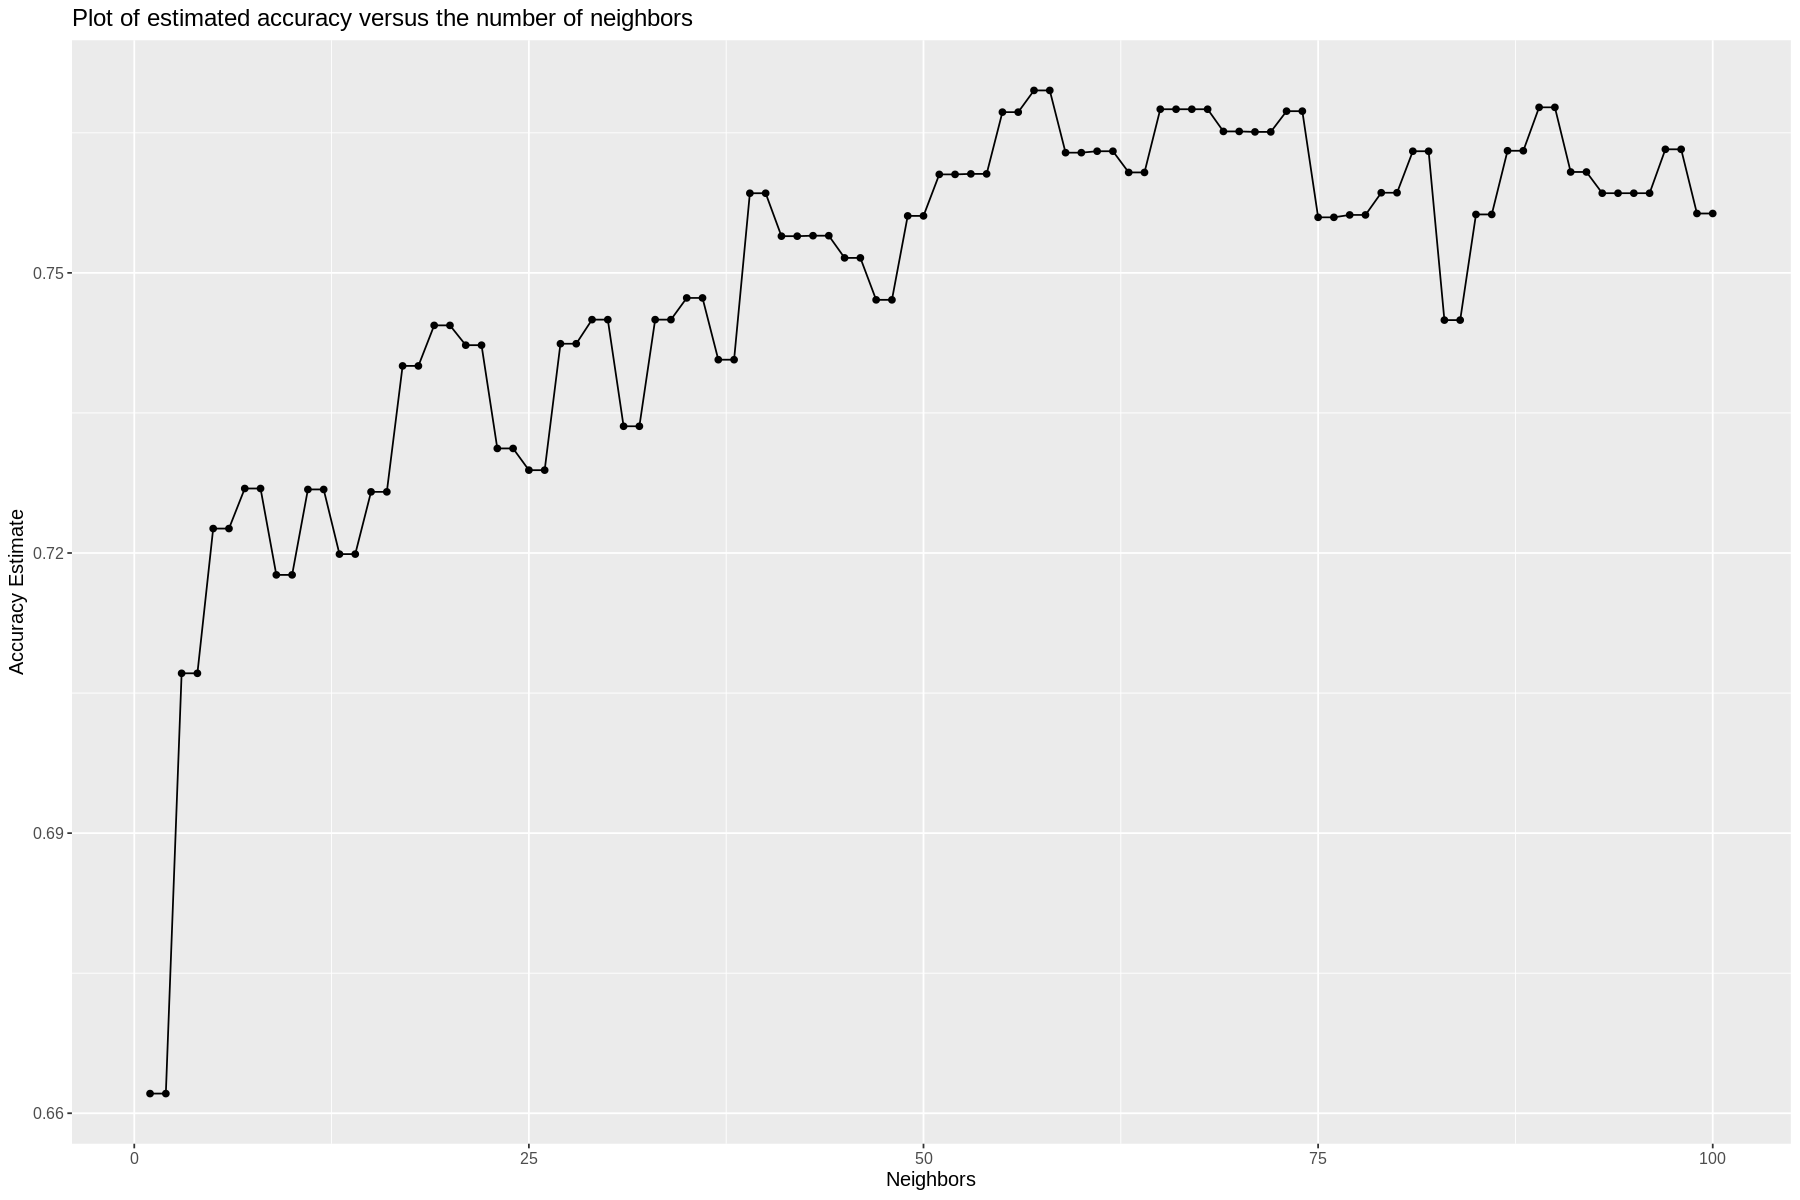

In [22]:
# K graph

options(repr.plot.height = 10, repr.plot.width = 15)
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12)) +
  ggtitle("Plot of estimated accuracy versus the number of neighbors")
accuracy_vs_k


**Graph 3.1**: Plot of estimated accuracy versus the number of neighbors



In [28]:
# Choose the best K
accuracies<- accuracies|>arrange(desc(mean)) |> slice(1)
accuracies 

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
57,accuracy,binary,0.7695396,10,0.02980972,Preprocessor1_Model057


**Table 3.4** Neighbours with best accuracy

    1) neighbors: number of neighbours used in classification
    2) .metric: they type of metric used for classifcation, used accuracy
    3) .estimator: type of the estimator, always binary here
    4) mean: mean of the model
    5) n: the number of folds done
    6) std_err: standard error of the model
    7) .config: configuation of the model 

In [29]:
# Build the final model
set.seed(1)
k_min <- accuracies|>select(neighbors) |> pull()
knn_spec_final <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
       set_engine("kknn") |>
       set_mode("classification")

stroke_fit <- workflow() |>
       add_recipe(stroke_recipe) |>
       add_model(knn_spec_final) |>
       fit(data = stroke_train_balance)

In [30]:
# Get the accuracy
set.seed(1)
stroke_test_predictions <- predict(stroke_fit , stroke_test) |>
       bind_cols(stroke_test) 
stroke_test_predictions


.pred_class,age,avg_glucose_level,bmi,stroke
<fct>,<dbl>,<dbl>,<dbl>,<fct>
1,80,105.92,32.5,1
1,81,186.21,29.0,1
1,74,70.09,27.4,1
⋮,⋮,⋮,⋮,⋮
0,1.08,79.15,17.4,0
0,68.00,91.68,40.8,0
0,45.00,97.95,24.5,0


**Table 3.4** Final predictions for the model

    1) .pred_class: the prediction of an example, 1 for stroke, 0 or no stroke
    2) age: age of example
    3) avg_glucose_level: average glucose level of example
    4) bmi: average bmi level of example
    5) stroke: the actual fat of the example, weather or not example had stroke or not

In [27]:
stroke_accuracy <- stroke_test_predictions |>
       metrics(truth = stroke, estimate = .pred_class) |> filter(.metric == "accuracy")
stroke_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7956026


**Table 3.5** Accuracy of final model

    1) .metric: accuracy
    2) .estimator: binary
    3) .estimate: accuracy value of model

In [31]:
set.seed(1)

stroke_mat <- stroke_test_predictions |> 
       conf_mat(truth = stroke, estimate = .pred_class)

stroke_mat

          Truth
Prediction   0   1
         0 940  16
         1 235  37

**Figure 3.1** Confusion matrix - Now after using test data we get see how many positive, negatives, false negatives and flase positive were classified

### Discussion

#### Summary

Our model shows that that peak accuracy is obtained at $k = 57$ (using 57 nearest neighbors for classification) in table 3.4. The model obtains roughly 77% accuracy, by table 3.4, when predicting strokes from new observations, which come from our split data for testing. 

Through experimentation with various downsampling ratios, a ratio of 1.85 yielded superior accuracy compared to a ratio of 1 to 5. 
To address the imbalanced nature of the dataset and its distinct characteristics, the unsampling method was selected as a means of dataset balancing and computational cost reduction. so our balance choose $under \ ratio = 1.85$

#### Expected outcomes

The model's accuracy turns out to be smaller than expected, around 77% when tested on new observations. This does not necessarily mean that the model is bad, however. According to Lee et al., in most cases, classifying a majority class observation as minority (in this case, false positive) are generally much better than the opposite (false negatives). It makes sense in our case why we want to avoid misclassifying as non-stroke, since doing so might put the patient and medical team in a passive state when there is a lurking danger of a stroke, and also there are no serious consequences if we classify a healthy person as stroke-likely. The confusion matrix shows this pattern, as it can detect a high number of stroke accurately, 37 out of 53 cases (even though it can be improved) and has a lot of false positives. 

We don't consider k values beyond 101 to avoid overfitting. While 57 is a quite big k value, we argue it's within reasonable range.

#### Impact

The impact of the findings is directly linked to the main question of this report. With this classification model, we can now accurately predict whether a person is likely to develop a stroke or not and look into whether a part of their lifestyle is significantly contributing to this probability. This means that the medical team can be proactive in their treatments if such unfortunate events occur, and for the patient, promote a healthy lifestyle change.

#### Future questions

Our model is based on downsampling. According to Lee et al., however, a disadvantage of downsampling method is that a loss of information is gauranteed since we are cutting down the data from the majority class, and if we're unlucky we may lose very useful information. Another approach to the problem is to instead use the upsampling method to fix the unbalanced data, although there is a risk of unnecessary duplication. Instead of cutting down or increase data size, a cost-sensitive learning approach (adding weights to each data point) can be rather effective (Lee et al., 2022).

By developing this stroke predictor, we hope to use a set of conditions that could potentially contribute to the development of strokes to predict whether an individual will develop their first stroke in the future. We will also examine the accuracy of this predictor for any future improvements. In a real-life setting, this predictor can be used for stroke prevention among high-risk patients and to promote lifestyle changes to reduce the risk of stroke. As this predictor only predicts the first stroke of an individual, while one in four stroke patients in the US (CDC, 2022) experiences a second stroke sometime in their life (Tsao et al., 2022), future work can be done to predict the chance of having multiple strokes based on a more extensive range of health conditions and it could raise new inquiries regarding additional risk factors that could improve the model.


## References 

Tsao, C. W., Aday, A. W., Almarzooq, Z. I., Alonso, A., Beaton, A. Z., Bittencourt, M. S., Boehme, A. K., Buxton, A. E., Carson, A. P., Commodore-Mensah, Y., Elkind, M. S. V., Evenson, K. R., Eze-Nliam, C., Ferguson, J. F., Generoso, G., Ho, J. E., Kalani, R., Khan, S. S., Kissela, B. M., & Knutson, K. L. (2022). Heart Disease and Stroke Statistics—2022 Update: A Report From the American Heart Association. Circulation, 145(8). https://doi.org/10.1161/cir.0000000000001052

Campbell, T., Lee, M., & Timbers, T. (2022). Data Science: A First Introduction. CRC Press. https://datasciencebook.ca/index.html

Lee, W., & Seo, K. (2022). Downsampling for Binary Classification with a Highly Imbalanced Dataset Using Active Learning. Big Data Research, 28, 100314. https://doi.org/10.1016/j.bdr.2022.100314

Dev, S., Wang, H., Nwosu, C. S., Jain, N., Veeravalli, B., & John, D. (2022). A predictive analytics approach for stroke prediction using machine learning and neural networks. Healthcare Analytics, 100032. https://doi.org/10.1016/j.health.2022.100032